코드 생성

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [98]:
OV = 10
ms = 120 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000

# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4?
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [99]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 158.49 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.000001

# 잡음의 크기 설정
num_samples = 1023 *20 * (ms//20) * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 
imaginary_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [100]:
data = []
for i in range(ms//20):
    data.append((1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

# data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)
        

cor_data = []
for value in data:
    cor_data.extend([value] * 20)


Signal 생성

In [101]:
class trans_signal:
    def __init__(self, code_delay, doppler_freq, svNumber, code_freq, bits, OV):
        self.delay = code_delay
        self.doppler = doppler_freq
        self.svNumber = svNumber
        
        self.seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
        t = np.arange(1023 * OV * 20 * bits)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV))
    def signal(self):
        return self.seq * self.oversampled_signal + complex_noise       

Replica 신호 생성

In [102]:
class Replica:
    def __init__(self, code_delay, doppler_freq, code_freq, svNumber, signal_length, OV, ts):
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip in ca_code for _ in range(OV)]
        
        t = np.arange(1023 * OV * ts, 1023 * OV * ts + 1023 * OV)
        self.delayed_code = np.roll(ca_code, code_delay)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV))
    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal

Acquisition

In [103]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, OV):
    
    # 신호 1ms씩 쪼개기
    sig = signal.signal()
    signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    dop_freq_max = []
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        # replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber, 1023 * OV, OV)
        replica = Replica(code_delay_range[0], doppler_freq, code_freq, svNumber, 1023 * OV, OV, 0)
        dop= []
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica.signal(), mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            dop.append(peak)
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            #replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            replica.delay(OV if OV == 1 else OV//2)
            
        dop_freq_max.append(max(dop))
        
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
    # 20ms 안에서 bit boundary(B) 값 탐색
    cor_lst = []
    for i in range(ms):
        True_replica = Replica(max_code_delay, max_doppler_freq, code_freq, svNumber, 1023 * OV, OV, i)
        cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
        cor_lst.append(np.max(cor))  
    phase_diff = []
    for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
  
    return max_code_delay, max_doppler_freq, cor_lst, corr_matrix, dop_freq_max
    

Acquisition 실행

In [104]:
code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (20*1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)

true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
# true_doppler_freq = -2750


received_signal = trans_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, ms//20, OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, cor_lst, corr_matrix, dop_max= acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40) 
print("B :", true_code_delay//(OV*1023))
B = true_code_delay//(OV*1023)
print()
for i in range(-10,11):
    print(f"{i*500}Hz : {dop_max[i+10]}")


----------------------------------------
Frame Sync completed.
Frame delay : 37.5
Estimated_Frequency Offset : 5000.0
Max correlation : 258.64544642632706
----------------------------------------

------------------ Test ------------------
Target SV Number: 34
True Code Delay: 17428.6
True doppler frequency: 4952
----------------------------------------
B : 17

-5000Hz : 92.50167355962662
-4500Hz : 92.79610456293395
-4000Hz : 82.96034472794925
-3500Hz : 88.37135284387749
-3000Hz : 89.45067151084149
-2500Hz : 87.0847198031322
-2000Hz : 96.43842072465385
-1500Hz : 85.52483057431982
-1000Hz : 87.45969632789881
-500Hz : 98.31150537948935
0Hz : 89.0224233847549
500Hz : 90.14261047554142
1000Hz : 91.53333782056708
1500Hz : 86.71721697161998
2000Hz : 85.76268838852693
2500Hz : 97.27143561716512
3000Hz : 109.13010743003973
3500Hz : 87.61875758318915
4000Hz : 89.82230782989704
4500Hz : 191.43583709718894
5000Hz : 258.64544642632706


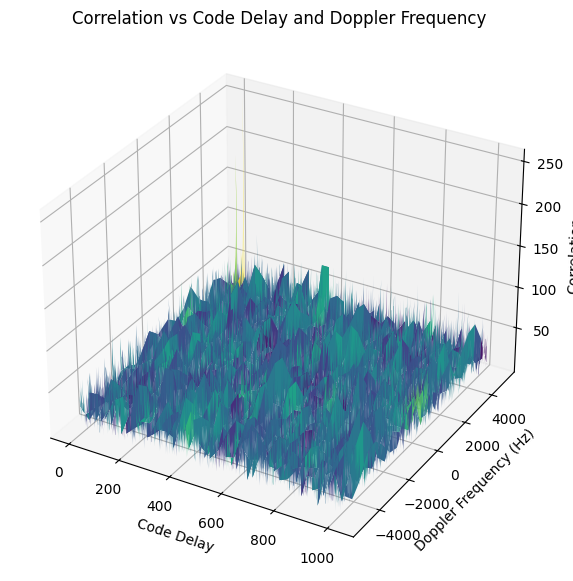

In [105]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



In [106]:
"""
print(B)
degree_list = [np.degrees(value) for value in phase_diff]
for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")

plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(0, 0 + 20)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()
print(cor_lst)
# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.
"""

'\nprint(B)\ndegree_list = [np.degrees(value) for value in phase_diff]\nfor idx, value in enumerate(degree_list):\n    print(f"Index {idx}: {value}")\n\nplt.figure(figsize=(8, 8))\nplt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)\n\nfor i, txt in enumerate(range(0, 0 + 20)):\n    plt.annotate(f\'{txt}\', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)\n    \nplt.title("Estimated correlation list")\nplt.xlabel("Real Part")\nplt.ylabel("Imaginary Part")\nplt.grid(True)\nplt.show()\nprint(cor_lst)\n# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)\n# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.\n'

FLL(Ignoring bit boundary)

In [107]:
# 신호 1ms씩 쪼개기
sig = received_signal.signal()
signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
est_code_del = estimated_code_delay
est_dopp = estimated_doppler_freq

for i in range(ms//20):
    
    #FLL
    # 20ms 안에서 
    cor_lst = []
    for j in range(5):
        True_replica = Replica(est_code_del, est_dopp, code_freq, svNumber, 1023 * OV, OV, i*20 + j)
        cor = correlate(signal_div[i*20 + j], True_replica.signal(), mode = 'valid')
        cor_lst.append(np.max(cor))  
    phase_diff = []
    for k in range(1, 5):
        R = cor_lst[k-1] * np.conjugate(cor_lst[k])
        phase_diff.append(np.degrees(np.arctan2(np.imag(R), np.real(R)))) 
    mean_diff = np.average(phase_diff)
    est_error_freq = 1000 * mean_diff / 360
    
    #update
    est_dopp = est_dopp - est_error_freq
    print(est_dopp)

print('estmated:',est_dopp)
print('true freq:', true_doppler_freq)


4954.709479513854
4954.2824213067215
4955.556758700433
4957.785160093833
4957.3523897704
4941.006991130637
estmated: 4941.006991130637
true freq: 4952
